In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import torch
from torch.utils.data import DataLoader

from data.scannet.utils_scannet import ScanNetDataset
from matching.gmflow_dense.gmflow_dense import GMflowDensePoseDeterministic
from flow_regressors.regressors import DensePoseRegressorV7

from training.train_deterministic import test
from utils.model import load_checkpoint
from utils.metrics import mAA, rotation_angle_distance_batch, vector_angle_distance_batch, mAA_max, mAA_sep

import numpy as np
from numpy.linalg import norm

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import pandas as pd 

from tqdm.auto import tqdm
import pickle
from pathlib import Path

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### 0. Data

In [6]:
test_data = ScanNetDataset(
    root_dir='/home/project/ScanNet/scannet_test_1500/',
    npz_path='/home/project/ScanNet/test.npz',
    intrinsics_path='/home/project/ScanNet/intrinsics_test.npz',
    calculate_flow=True
)

test_loader = DataLoader(test_data, batch_size=4, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

## 1. Metrics

In [5]:
metrics = {}

if Path('/home/project/code/results/scannet/metrics_gmflow').is_file():
    with open('/home/project/code/results/scannet/metrics_gmflow', 'rb') as f:
        metrics = pickle.load(f)

### 1. Without fine-tuning (on coarse flow)

In [8]:
checkpoint_gmflow = load_checkpoint(
    '/home/project/code/src/matching/gmflow/weights/pretrained/gmflow_with_refine_kitti-8d3b9786.pth',
    device)

checkpoint_regressor = load_checkpoint(
    '/home/project/code/src/weights/COARSE_FLOW_EXP_1_4.pth',
    device)

In [9]:
regressor = DensePoseRegressorV7(init_loss_weights=[0.0, -3.0, -3.0])
regressor.load_state_dict(checkpoint_regressor['model'])

model = GMflowDensePoseDeterministic(regressor, fine_tuning=False)
model.flow_module.load_state_dict(checkpoint_gmflow['model'])

model.to(torch.float32)
model.to(device);

In [10]:
results = test(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:14<00:00,  1.47it/s]


In [11]:
name = "GMFlow pretrained + shallow, w/o ft"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [12]:
name = "GMFlow pretrained + shallow, w/o ft"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.0819
mAA 10 rotation      0.2121
mAA 20 rotation      0.3810


### 2. With fine-tuning (only last 2 stages)

In [14]:
checkpoint = load_checkpoint('/home/project/code/src/weights/DETERMINISTIC_FT_4.pth',
                             device)

In [15]:
regressor = DensePoseRegressorV7(init_loss_weights=[0.0, -3.0, -3.0])
model = GMflowDensePoseDeterministic(regressor, fine_tuning=False)
model.load_state_dict(checkpoint['model'])

model.to(torch.float32)
model.to(device);

In [16]:
results = test(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:08<00:00,  1.51it/s]


In [17]:
name = "GMFlow pretrained + shallow, ft 2 stages"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [18]:
name = "GMFlow pretrained + shallow, ft 2 stages"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.1245
mAA 10 rotation      0.2895
mAA 20 rotation      0.4681


### 2. With fine-tuning (all stages)

In [19]:
checkpoint = load_checkpoint('/home/project/code/src/weights/DETERMINISTIC_FT_part2_4.pth',
                             device)

In [20]:
regressor = DensePoseRegressorV7(init_loss_weights=[0.0, -3.0, -3.0])
model = GMflowDensePoseDeterministic(regressor, fine_tuning=False)
model.load_state_dict(checkpoint['model'])

model.to(torch.float32)
model.to(device);

In [21]:
results = test(model, test_loader, device)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 375/375 [04:08<00:00,  1.51it/s]


In [22]:
name = "GMFlow pretrained + shallow, all stages"
metrics[name] = {
    'R_angle_distances': rotation_angle_distance_batch(results['R_gt'], results['R']),
    't_angle_distances': vector_angle_distance_batch(results['t_gt'], results['t']),
    't_distances_l2': norm(results['t_gt'] - results['t'], ord=2, axis=1),
    'R_gt_distances': rotation_angle_distance_batch(results['R_gt'], np.tile(np.eye(3, 3), (results['R_gt'].shape[0], 1, 1))),
    't_gt_distances': norm(results['t_gt'], ord=2, axis=1)
}

In [23]:
name = "GMFlow pretrained + shallow, all stages"
print(f'{"mAA 5 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(5, 0.2), N=10000):.4f}')
print(f'{"mAA 10 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(10, 0.5), N=10000):.4f}')
print(f'{"mAA 20 rotation":<20} {mAA(metrics[name]["R_angle_distances"], metrics[name]["t_distances_l2"], thresh=(20, 1), N=10000):.4f}')

mAA 5 rotation       0.1692
mAA 10 rotation      0.3734
mAA 20 rotation      0.5615


#### Saving metrics

In [24]:
with open('/home/project/code/results/scannet/metrics_gmflow', 'wb') as f:
    pickle.dump(metrics, f)

# 2. Results
### 2.1 Table form


In [25]:
df = pd.DataFrame(index=metrics.keys())

for q in (0.25, 0.5, 0.75, 0.9):
    df[f'R_q={q}'] = None
    df[f't_q={q}'] = None
    df[f'angle_t_q={q}'] = None
    for key, val in metrics.items():
        df.loc[key, f't_q={q}'] = np.quantile(val["t_distances_l2"], q)
        df.loc[key, f'R_q={q}'] = np.quantile(val["R_angle_distances"], q)
        df.loc[key, f'angle_t_q={q}'] = np.quantile(val["t_angle_distances"], q)
        d = df.style.format(precision=2)
df.sort_index(axis=1, inplace=True)


for col in df.columns:
    d.background_gradient(cmap="RdYlGn_r", subset=col)
d

,R_q=0.25,R_q=0.5,R_q=0.75,R_q=0.9,angle_t_q=0.25,angle_t_q=0.5,angle_t_q=0.75,angle_t_q=0.9,t_q=0.25,t_q=0.5,t_q=0.75,t_q=0.9
"GMFlow pretrained + shallow, w/o ft",4.92,10.74,27.33,56.05,19.49,39.43,72.53,115.68,0.18,0.45,1.04,1.94
"GMFlow pretrained + shallow, ft 2 stages",3.51,8.04,20.82,48.42,12.41,26.12,54.43,97.42,0.14,0.35,0.85,1.79
"GMFlow pretrained + shallow, all stages",2.85,5.71,13.59,33.69,8.80,17.71,33.83,61.57,0.11,0.25,0.60,1.43


In [6]:
df = pd.DataFrame(index=metrics.keys())

for t in (5, 10, 20, 30):
    df[f'mAA_R_{t}'] = None
    df[f'mAA_t_{t}'] = None
    df[f'mAA_max_{t}'] = None
    for key, val in metrics.items():
        df.loc[key, f'mAA_R_{t}'] = mAA_sep(val["R_angle_distances"], t, 10000)
        df.loc[key, f'mAA_t_{t}'] = mAA_sep(val["t_angle_distances"], t, 10000)
        df.loc[key, f'mAA_max_{t}'] = mAA_max(val["R_angle_distances"], val["t_angle_distances"], t, 10000)
        d = df.style.format(precision=2)
df.sort_index(axis=1, inplace=True)
df.sort_index(axis=0, inplace=True)

for col in df.columns:
    d.background_gradient(cmap="RdYlGn", subset=col)
d

,mAA_R_10,mAA_R_20,mAA_R_30,mAA_R_5,mAA_max_10,mAA_max_20,mAA_max_30,mAA_max_5,mAA_t_10,mAA_t_20,mAA_t_30,mAA_t_5
"GMFlow pretrained + shallow, all stages",0.39,0.57,0.67,0.20,0.09,0.24,0.36,0.02,0.12,0.27,0.40,0.04
"GMFlow pretrained + shallow, ft 2 stages",0.31,0.49,0.59,0.16,0.06,0.16,0.25,0.01,0.07,0.19,0.29,0.02
"GMFlow pretrained + shallow, w/o ft",0.24,0.41,0.52,0.11,0.03,0.09,0.16,0.01,0.04,0.11,0.18,0.01


### 2.2 Plots

In [10]:
plt.style.use('default')

rc('text', usetex=True)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

rc('font', size=MEDIUM_SIZE)          # controls default text sizes
rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [9]:
def calculate_metric_on_subset(metric_values, values_dependent_on, agg_func, thresholds, sign):
    thresholds_ = thresholds[:, None]
    if sign == '>':
        inliers_bool = values_dependent_on > thresholds_
    else:
        inliers_bool = values_dependent_on <= thresholds_
    scores = np.array([agg_func(metric_values[subset]) for subset in inliers_bool])
    return scores

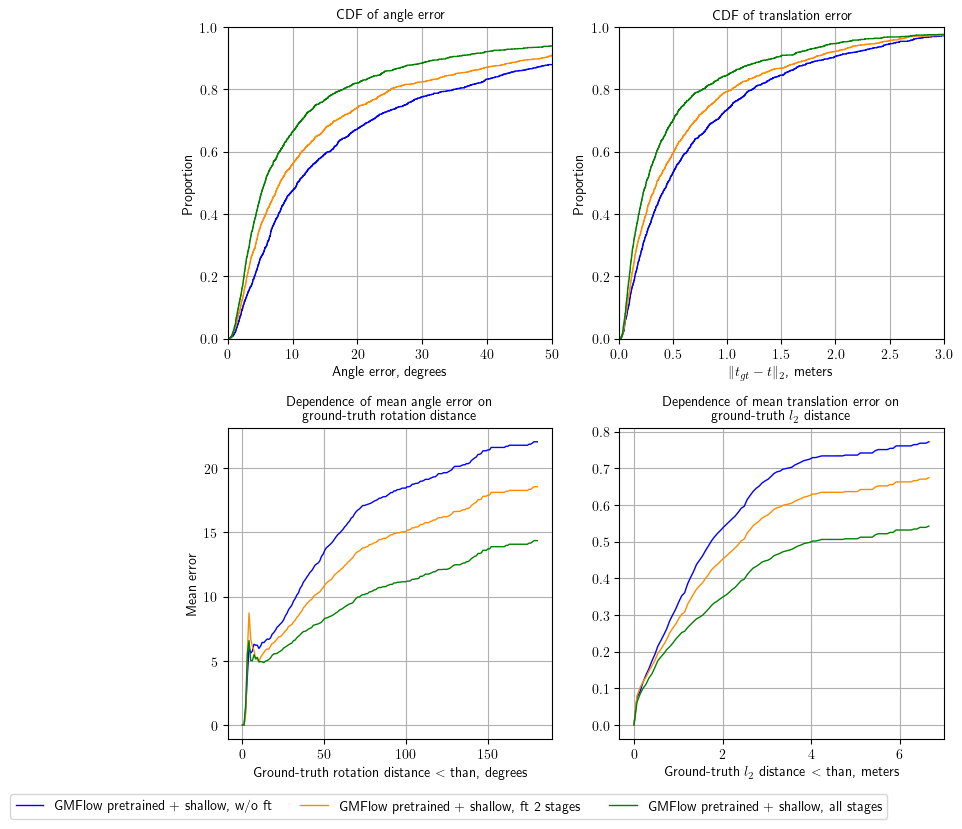

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

colors = ['b', 'darkorange' ,'g' ,'r' ,  '#8B008B',
          '#A52A2A','#FFC0CB','#808080','#556B2F','#00FFFF',
         '#FF00FF','#32CD32','#008080','#E6E6FA',
         '#D2B48C','#FA8072','#FFD700', '#000080']

exp_colors = {exp: col for  exp, col in zip(metrics.keys(), colors)}

for exp, m in metrics.items():
    sns.ecdfplot(x=m['R_angle_distances'], complementary=False, ax=ax[0,0], c=exp_colors[exp], linewidth=1)
    ax[0, 0].set_xlim([0., 50.])
    sns.ecdfplot(x=m['t_distances_l2'], complementary=False, ax=ax[0,1], c=exp_colors[exp], linewidth=1, log_scale=False)
    ax[0, 1].set_xlim([0., 3.])
    R_on_gt = calculate_metric_on_subset(
        m['R_angle_distances'], m['R_gt_distances'], np.mean, np.linspace(0, 180, 180), '<')
    R_on_gt[np.isnan(R_on_gt)] = 0
    ax[1, 0].plot(np.linspace(0, 180, 180), R_on_gt, label=exp, c=exp_colors[exp], linewidth=1)
    
    t_on_gt = calculate_metric_on_subset(
        m['t_distances_l2'], m['t_gt_distances'], np.mean, np.linspace(0, 6.66, 100), '<')
    t_on_gt[np.isnan(t_on_gt)] = 0
    ax[1, 1].plot(np.linspace(0, 6.66, 100), t_on_gt, c=exp_colors[exp], linewidth=1)
    
    
# ax[0, 0].vlines([5, 10, 20, 30], ymin=0, ymax=1)
ax[0, 0].set_xlabel('Angle error, degrees')
ax[0, 0].set_title('CDF of angle error')
ax[0, 0].grid()


# ax[0, 1].vlines([0.25, 0.5, 5], ymin=0, ymax=1)

# n_bins = 100 # number of bins for histogram calculation 
# counts, bin_edges = np.histogram(sorted(fx), bins=n_bins)
# cdf_values = np.cumsum(counts)/len(sorted(fx))
# bin_centers = (bin_edges[1:]+bin_edges[:-1])/2.
# ax2=ax1.twinx() # create secondary axis with shared x-axis  
# ax[0, 1].step(bin_centers,cdf_values,'r--')
# ax[0, 1].set_ylabel('Fraction of observations')

ax[0, 1].set_xlabel('$\|t_{gt} - t\|_2$, meters')
ax[0, 1].set_title('CDF of translation error')
ax[0, 1].grid()

ax[1, 0].set_xlabel('Ground-truth rotation distance $<$ than, degrees')
ax[1, 0].set_ylabel('Mean error')
ax[1, 0].set_title('Dependence of mean angle error on \n ground-truth rotation distance')
ax[1, 0].grid()


ax[1, 1].set_xlabel('Ground-truth $l_2$ distance $<$ than, meters')
ax[1, 1].set_title('Mean error, meters')
ax[1, 1].set_title('Dependence of mean translation error on \n ground-truth $l_2$ distance')
ax[1, 1].grid()


handles, labels = ax[1, 0].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(.9, 0), borderaxespad=0.0, ncol=5)
fig.tight_layout()
plt.savefig('/home/project/code/results/images/scannet_cdfs_gt_flow.pdf', bbox_inches='tight')